In [1]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# from sklearn.pipeline import Pipeline, make_pipeline
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import FeatureUnion

# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm
# import catboost as catb

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, log_loss
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
import itertools

import shap
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from functools import partial
from hyperopt import hp, fmin, tpe, space_eval, Trials, STATUS_OK

In [3]:
df = pd.read_csv('course_project_train.csv')
df.head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [4]:
df['Credit Default'].value_counts(normalize=True)

0    0.718267
1    0.281733
Name: Credit Default, dtype: float64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [6]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [7]:
for cat_colname in df[df.columns].select_dtypes(include = 'object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

**to do**

* **Home Ownership** - уменьшаем количество вариантов 
* **Annual Income** - Nan fill
* **Years in current job** - убираем year, 10+ -> 10, <1 -> 0, Nan
* **Tax Liens** - 
* **Number of Open Accounts** - 
* **Years of Credit History** - 
* **Maximum Open Credit** - 
* **Number of Credit Problems** - 
* **Months since last delinquent** - Nan -> 99999999 (не было проблем)
* **Bankruptcies** - Nan fill
* **Purpose** - уменьшаем количество вариантов
* **Term** - 
* **Current Loan Amount** - 
* **Current Credit Balance** - 
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - Nan fill

In [8]:
def data_preprocessing(X):

    X['Years in current job'] = X['Years in current job'].replace(regex = True, to_replace = r'\W\s\D+$|\s\D+$', value = '').replace('< 1', 0)
#     X.loc[X['Years in current job'].isna(), 'Years in current job'] = df['Years in current job'].median()
    X['Years in current job'] = pd.to_numeric(X['Years in current job'], errors='coerce').astype(pd.Int64Dtype())

    X.loc[df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
    X.loc[~df['Purpose'].isin(['debt consolidation', 'other', 'home improvements', 'business loan']), 'Purpose'] = 'other'
    
    for col in X.select_dtypes(include='object').columns:
        X[col] = X[col].astype('category')

    X.loc[X['Months since last delinquent'].isna(), 'Months since last delinquent'] = 99999999

    X.loc[X['Bankruptcies'].isna(), 'Bankruptcies'] = df['Bankruptcies'].value_counts().idxmax()

#     X.loc[X['Credit Score'] > 999, 'Credit Score'] = X.loc[X['Credit Score'] > 1000, 'Credit Score'] // 10
    
    return X

In [9]:
df = data_preprocessing(df)

In [10]:
df_cat = df.select_dtypes(include='category')
df_num = df.select_dtypes(exclude='category')
df_num = df_num.drop(['Credit Default'], axis = 1)
df_target = df['Credit Default']

In [11]:
## fill nan
imputer = IterativeImputer(max_iter = 100)
imp_arr = pd.DataFrame(imputer.fit_transform(df_num))
imp_arr.columns = df_num.columns
df = pd.concat([df_cat, imp_arr], axis = 1)
df = pd.concat([df, df_target], axis = 1)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Purpose                       7500 non-null   category
 2   Term                          7500 non-null   category
 3   Annual Income                 7500 non-null   float64 
 4   Years in current job          7500 non-null   float64 
 5   Tax Liens                     7500 non-null   float64 
 6   Number of Open Accounts       7500 non-null   float64 
 7   Years of Credit History       7500 non-null   float64 
 8   Maximum Open Credit           7500 non-null   float64 
 9   Number of Credit Problems     7500 non-null   float64 
 10  Months since last delinquent  7500 non-null   float64 
 11  Bankruptcies                  7500 non-null   float64 
 12  Current Loan Amount           7500 non-null   fl

In [13]:
df['Credit Default'].groupby(df['Home Ownership']).sum()

Home Ownership
Home Mortgage     918
Own Home          192
Rent             1003
Name: Credit Default, dtype: int64

In [14]:
df['Credit Default'].groupby(df['Purpose']).sum()

Purpose
business loan           55
debt consolidation    1654
home improvements      108
other                  296
Name: Credit Default, dtype: int64

In [15]:
df['Credit Default'].groupby(df['Term']).sum()

Term
Long Term      816
Short Term    1297
Name: Credit Default, dtype: int64

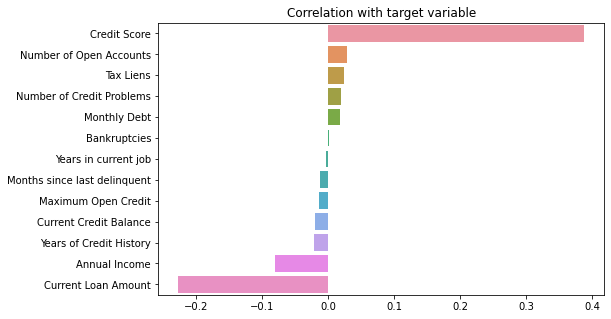

In [16]:
corr_with_target = df[df.columns.drop('Credit Default').tolist() + ['Credit Default']].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable');

Корреляция некоторых фичей с таргетом достаточно сильная, может получиться хорошо разделимое пространство

In [17]:
TARGET_NAME = 'Credit Default'
FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
CAT_FEATURE_NAMES = [col for col in df.select_dtypes(include='category').columns]
NUM_FEATURE_NAMES = [col for col in df.select_dtypes(include='float64').columns]

In [18]:
NUM_FEATURE_NAMES

['Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [19]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES]) 
df_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Purpose                       7500 non-null   category
 2   Term                          7500 non-null   category
 3   Annual Income                 7500 non-null   float64 
 4   Years in current job          7500 non-null   float64 
 5   Tax Liens                     7500 non-null   float64 
 6   Number of Open Accounts       7500 non-null   float64 
 7   Years of Credit History       7500 non-null   float64 
 8   Maximum Open Credit           7500 non-null   float64 
 9   Number of Credit Problems     7500 non-null   float64 
 10  Months since last delinquent  7500 non-null   float64 
 11  Bankruptcies                  7500 non-null   float64 
 12  Current Loan Amount           7500 non-null   fl

In [20]:
#разделим данные на train/test
X = df_norm[NUM_FEATURE_NAMES + CAT_FEATURE_NAMES]
y = df_norm[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [21]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5625, 16), (5625,), (1875, 16), (1875,))

In [22]:
model = lgbm.LGBMClassifier(random_state = 42)
model.fit(X_train, y_train, categorical_feature = CAT_FEATURE_NAMES)
y_pred = model.predict(X_test)
y_pred_probs = model.predict_proba(X_test)[:, 1]

categorical_feature in Dataset is overridden.
New categorical_feature is ['Home Ownership', 'Purpose', 'Term']


In [23]:
def evaluate_results(y_test, y_predict):
    f1 = f1_score(y_test, y_predict)
    roc = roc_auc_score(y_test, y_predict)
    rec = recall_score(y_test, y_predict, average='binary')
    prc = precision_score(y_test, y_predict, average='binary')

    return roc, f1, prc, rec

In [24]:
def get_classifier_metrics(y_test, y_score):
    b = 1
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)

    roc_auc = roc_auc_score(y_true=y_test, y_score = y_score)
    return roc_auc, fscore[ix], precision[ix], recall[ix], thresholds[ix]

In [25]:
evaluate_results(y_test, y_pred)

(0.6463289362059665,
 0.47337278106508873,
 0.7067137809187279,
 0.35587188612099646)

### params hyperopt

In [26]:
train_c = lgbm.Dataset(X_train, y_train, free_raw_data=False)
test_c = lgbm.Dataset(X_test, y_test, free_raw_data=False)

In [27]:
# функция потерь
def eval_logloss(preds, train_data):
    labels = train_data.get_label()
    return 'logloss', np.mean(labels != (preds > 0.5)), False

In [28]:
# Определим функцию для оптимизации гиперпараметров алгоритмом TPE

def objective(params, cv_params, data):
    if 'max_depth' in params.keys():
        params['max_depth'] = int(params['max_depth'])
        
#     booster = lgbm.Booster(params = lgb_fit_params)
    res = lgbm.cv(params=params, train_set=data, categorical_feature = CAT_FEATURE_NAMES, **cv_params)
    cv_result = pd.DataFrame.from_dict(res, orient='index')
    name = [i for i in cv_result.columns][-1]
    score = cv_result[name][-1:].values[0]
    return {'loss': score, 'status': STATUS_OK}

In [29]:
# Определим параметры выполнения кроссвалидации

cv_params = {'num_boost_round': 300,
             'nfold': 5,
             'shuffle': True,
             'stratified': False,
             'feval': eval_logloss,
#              'maximize': False,
             'early_stopping_rounds': 20
              }

In [30]:
lgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'num_leaves': hp.choice('num_leaves', np.arange(6, 20, 2, dtype = int)),
    'max_depth':        hp.choice('max_depth', np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     hp.choice('n_estimators', [100, 500, 1000, 1500]),
    'random_state': 42,
}

In [31]:
trials = Trials()
best = fmin(fn=partial(objective, cv_params=cv_params, data=train_c),
            space=lgb_reg_params, trials=trials, algo=tpe.suggest, max_evals=50, timeout=3600)

  0%|                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]

Found `n_estimators` in params. Will use it instead of argument

categorical_feature in Dataset is overridden.
New categorical_feature is ['Home Ownership', 'Purpose', 'Term']



100%|██████████████████████████████████████████████| 50/50 [00:21<00:00,  2.28trial/s, best loss: 0.008115706460809483]


In [32]:
best_params = space_eval(lgb_reg_params, best)
best_params

{'learning_rate': 0.2,
 'max_depth': 13,
 'min_child_weight': 6,
 'n_estimators': 500,
 'num_leaves': 14,
 'random_state': 42,
 'subsample': 0.8703482924525522}

In [33]:
# best = {'learning_rate': 0.2,
#  'max_depth': 12,
#  'min_child_weight': 7,
#  'n_estimators': 500,
#  'num_leaves': 14,
#  'random_state': 42,
#  'subsample': 0.9009069789715309}

In [34]:
model_new = lgbm.LGBMClassifier(**best_params)
model_new.fit(X_train, y_train, categorical_feature = CAT_FEATURE_NAMES)
y_pred = model_new.predict(X_test)
y_pred_probs = model.predict_proba(X_test)[:, 1]

evaluate_results(y_test, y_pred)

(0.6462245868714986,
 0.48245614035087714,
 0.6285714285714286,
 0.3914590747330961)

In [35]:
roc_auc, fscore, precision, recall, threshold = get_classifier_metrics(y_test, y_pred_probs)
roc_auc, fscore, precision, recall, threshold

(0.7535607516404528,
 0.556166535742341,
 0.4978902953586498,
 0.6298932384341637,
 0.27180482417809915)

In [36]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
      
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.axhline(0.5, color="red")
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=0.5)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

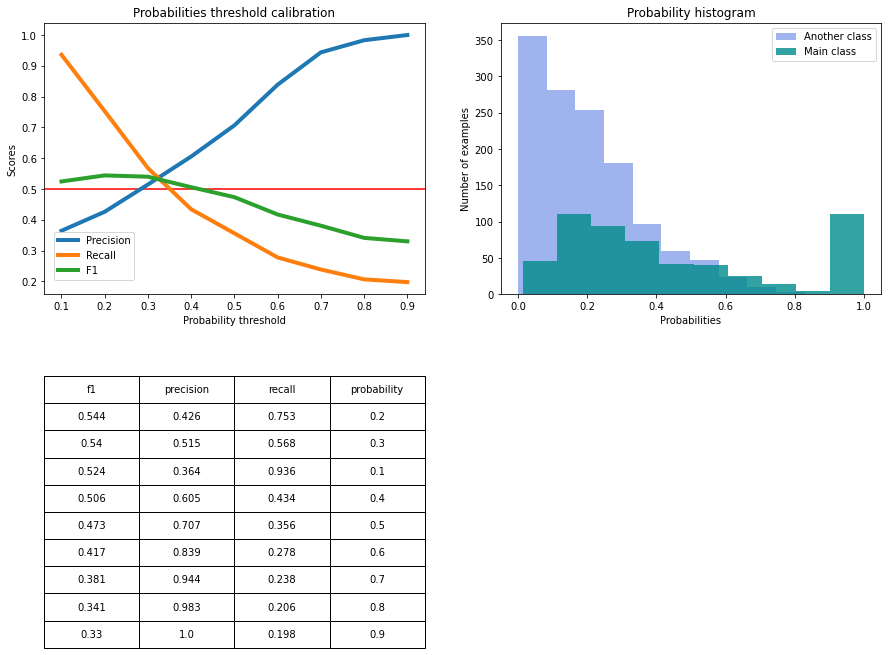

In [37]:
show_proba_calibration_plots(y_pred_probs, y_test)

### SHAP

In [38]:
model_new = lgbm.LGBMClassifier(**best_params)
model_new.fit(X_train, y_train, categorical_feature = CAT_FEATURE_NAMES)
y_pred_probs = model_new.predict_proba(X_train)[:, 1]

categorical_feature in Dataset is overridden.
New categorical_feature is ['Home Ownership', 'Purpose', 'Term']


In [39]:
# строим модель объЯсненияе в SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)

explainer = shap.TreeExplainer(model_new)

shap.initjs()
shap_values = explainer.shap_values(X_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [40]:
# Because the LGBMClassifier has two outputs (one for each class), shap_values is a list of two arrays. 
# Each array explains each of the outputs of the model. 
# In order to make a dependence plot for the first model output pass shap_values[0] instead of shap_values.

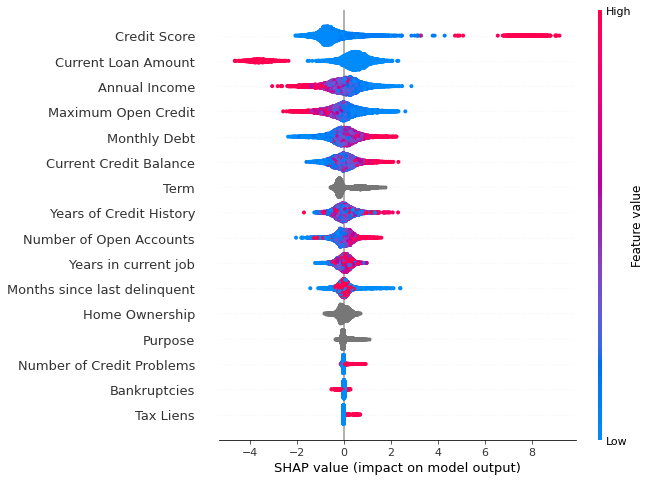

In [41]:
# summarize the effects of all the features
shap.summary_plot(shap_values[1], X_train)

Наиболее важными признаками для принятия решения являются кредитный рейтинг, размер кредита, наибольший размер открытого кредита и ежегодный доход. Любопытно, что все перечисленные признаки сильно коррелируют с целевой переменной (см. выше, ячейка 16), за исключением одного - Maximum open credit: он с целевой переменной коррелирует не сильно, но, тем не менее, является одним из важных для модели при принятии решения

In [42]:
#Выберем топ 10% датасета по убыванию предикта
X_train_preds = pd.concat([X_train, pd.Series(y_pred_probs, name = 'preds', index = X_train.index)], axis = 1)
X_train_preds = X_train_preds.sort_values(by = 'preds', ascending=False)
n = int(X_train_preds.shape[0] * 0.1)
top10_ind = X_train_preds.iloc[:n, :].index
top10_ind

Int64Index([7192, 7076, 3867, 6798, 3726, 1418, 4853, 5961, 5480, 7354,
            ...
            4790, 1157,  990, 1230, 5575, 2113, 5479, 4094, 1521, 2630],
           dtype='int64', length=562)

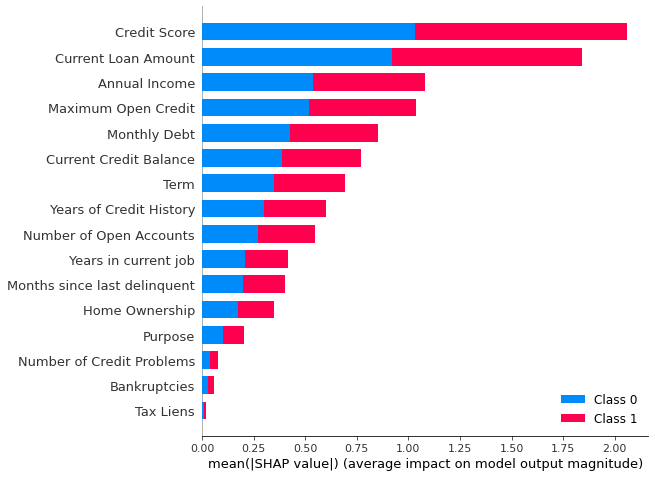

In [43]:
shap.summary_plot(shap_values, X_train.loc[top10_ind])

In [44]:
# shap.force_plot(explainer.expected_value, shap_values[:562,:], X_train.iloc[:562,:])

Рассмотрим два объекта, принадлежащие разным классам. Если в первом случае объект причислен к классу 0, в основном, по небольшому Credit Balance и краткому сроку кредита, то на решение причислить к классу 1 второй объект больше сыграли роль максимальный открытый кредит, ежемесячный платеж и текущий размер кредита

In [45]:
#class 1
shap.force_plot(explainer.expected_value[1], shap_values[1][352,:], X_train.iloc[352,:])

In [46]:
X_train.iloc[352,:]

Annual Income                       -0.136232
Years in current job                 -1.10248
Tax Liens                           -0.110953
Number of Open Accounts             -0.841571
Years of Credit History             -0.556342
Maximum Open Credit                -0.0384376
Number of Credit Problems           -0.340979
Months since last delinquent         0.915306
Bankruptcies                        -0.337099
Current Loan Amount                 -0.362485
Current Credit Balance              -0.813463
Monthly Debt                         0.117185
Credit Score                        0.0368675
Home Ownership                           Rent
Purpose                         business loan
Term                               Short Term
Name: 1305, dtype: object

In [47]:
#class 1
shap.force_plot(explainer.expected_value[1], shap_values[1][1,:], X_train.iloc[1,:])

In [48]:
X_train.iloc[1,:]

Annual Income                         1.48959
Years in current job                 0.535131
Tax Liens                           -0.110953
Number of Open Accounts             -0.434123
Years of Credit History               1.53129
Maximum Open Credit                -0.0516443
Number of Credit Problems           -0.340979
Months since last delinquent         -1.09253
Bankruptcies                        -0.337099
Current Loan Amount                 -0.348046
Current Credit Balance              -0.627259
Monthly Debt                          2.73106
Credit Score                       -0.0238991
Home Ownership                  Home Mortgage
Purpose                                 other
Term                               Short Term
Name: 3753, dtype: object